## *Brazilian E-commerce Insights*

## *Data Mining*

 *Data Mining is the process of `discovering patterns`, `relationships`, and useful insights from large sets of data. It’s like finding valuable information hidden in a big pile of data*

### *Importing Libraries*

In [84]:
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns  
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
from sklearn.preprocessing import StandardScaler 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from wordcloud import WordCloud  # For generating word clouds from text data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from transformers import pipeline


#Text Processing Libraries
import random

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

colors = ["#26536f", "#3b96b7", "#749ca8", "#b6a98d", "#c78a4d", "#854927"]

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Snit
[nltk_data]     Kahsay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Snit
[nltk_data]     Kahsay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [85]:
df = pd.read_parquet('../data/final/olist_full_data_Loaded.parquet', engine='pyarrow')

## *1.Clustering (Unsupervised Learning)*
*Clustering is an unsupervised machine learning technique used to group similar data points together into clusters — where each group shares more similarities with each other than with those in other groups.*

### *K-Means*:
*K-Means clustering uses Euclidean distance to measure the distance between data points and cluster centroids.*
mathmatical formula for K-Means clustering is:
$$J = \sum_{i=1}^{k} \sum_{x_j \in C_i} ||x_j - \mu_i||^2$$
where:  
- \(J\) is the objective function (total distance within clusters)
- \(k\) is the number of clusters



### *I .Data Preprocessing for K-Means*
#### *Step 1:Choose Relevant Columns for Clustering*

*Since K-Means works only with numerical values, we need to pick columns that are:Meaningful for identifying groups of similar orders or customers*
- *Numerical*

In [86]:
features_to_cluster =  ['monetary_value', 'purchase_frequency', 'recency_days','review_score', 'profit_margin']
df_cluster = df[features_to_cluster].copy()

| *Feature*                  | *Meaning*                               | *Cluster Interpretation Example*                        |
|----------------------------|------------------------------------------|----------------------------------------------------------
| *review_score*             | *Customer satisfaction*                  | *Happy vs. unhappy buyers*                               |
|*profit_margin*              | *Profit margin of the product*          | *High vs. low profit margin products*                    |
| *recency_days*             | *Days since last purchase*               | *Recent vs. old customers*                               |
| *purchase_frequency*       | *How often the customer buys*            | *Frequent vs. rare buyers*                               |
| *monetary_value*           | *Total money spent by customer*          | *High-value vs. low-value customers*                     |
                           |


#### *Step 2: Handling Missing Values*

In [87]:
df_cluster.isnull().sum()
#checking if there are any inf or -inf values
print(np.isinf(df_cluster).sum())

monetary_value        0
purchase_frequency    0
recency_days          0
review_score          0
profit_margin         0
dtype: int64



#### *Step 3: Scaling the Data*
*K-Means is distance-based, so we must scale all features so that one with large values (e.g., monetary_value) doesn't dominate the clustering.*
##### *Mathematically*:

$$
z = \frac{x - \mu}{\sigma}
$$  
*Each column has mean = 0 and standard deviation 1*




In [88]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

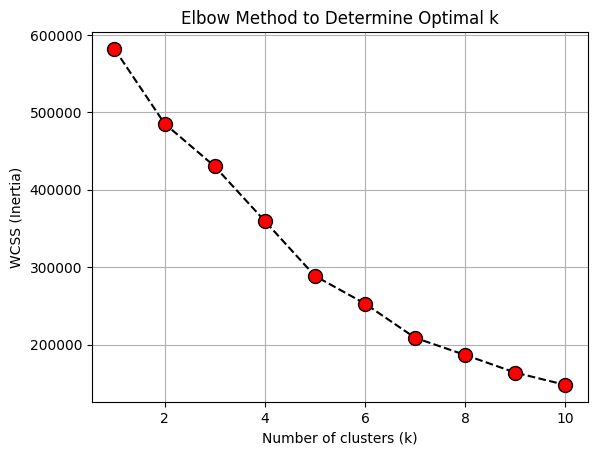

In [89]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss,  linestyle='--', color='black',marker='o' , markerfacecolor='red', markersize=10)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()



### *Elbow Method Insights*
---

*Optimal Number of Clusters (k):*

*The "elbow" of the curve is at k=6, where the rate of decrease in WCSS slows down significantly.*
*This suggests that k=6 is the optimal number of clusters, balancing fit and simplicity.*

*Key Observations:*

*Sharp Drop: Between k=2 and k=4, WCSS decreases rapidly, indicating strong improvement in clustering.*

*Plateau: Beyond k=6, the curve flattens, showing minimal improvement in WCSS. Adding more clusters may lead to overfitting.*

*Recommendations:*

*Best Choice: k=6 captures the main structure with minimal complexity.*

*Alternative: k=4 can be considered if domain knowledge supports subgroups.*

*Avoid: k > 6 as gains are minimal, and interpretability decreases.*

*Business Implications*
*Using `k=6` clusters can help identify distinct customer groups for targeted marketing, loyalty programs, or operational improvements.*

---


#### *III.Choosing and Applying  k=6*
*Based on the elbow method, we choose k=6 as the optimal number of clusters for our K-Means model.*
The following  steps will be:

*Applying  K-mean algorithm with k=6 to the dataset and assigning each data point to its respective cluster.*

*Then fit the model to the data and predict the cluster labels for each data point.*



In [90]:
final_k = 6
kmeans = KMeans(n_clusters=final_k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(scaled_data)

### *IV.Cluster Profiling – Understanding Each Cluster*
*Why Cluster Profiles Matter :will answer the question of what each cluster represents and how to use it for business decisions.*

Some of the questions that cluster profiles can help answer include:
- *Are some clusters high-value customers?*
- *Do some clusters represent low-profit, high-weight products?*
- *How do the clusters differ in terms of customer behavior?*
- *What marketing strategies can be tailored for each cluster?*                     

In [91]:
df_cluster=df_cluster.groupby('cluster').mean(numeric_only=True).round(2)

### *Key Observations:*

---

*🔵Cluster 0: Moderate overall metrics, with a strong review score (4.66), suggesting customers are fairly satisfied.*
*May be retained with regular engagement.*

*🔴Cluster 1: Low review score (1.59) despite fair monetary value and profit margin.*
*Could signal service/product issues that require quality improvement.*

*🟠Cluster 2: Extremely high monetary value (109,312.64) and profit margin (13,636.07) — but alarmingly low review score (1.00). Represents dissatisfied but valuable clients, possibly bulk buyers or B2B clients needing better service follow-up.*

*🟡Cluster 3: Similar in profile to Cluster 0, but extremely high recency (397.64) indicates inactivity.*
*Should be re-engaged through reactivation campaigns.*

*🟢Cluster 4: High monetary value (7,544.95) and strong profit margin (1,486.24) — possibly premium customers.*
*Slightly lower satisfaction (3.51), which may be improved to strengthen loyalty.*

*💙Cluster 5: High purchase frequency (7.11) with a solid review score (4.41) and decent monetary value.*
*Highly loyal and satisfied customers — best candidates for loyalty programs or special offers.*

---


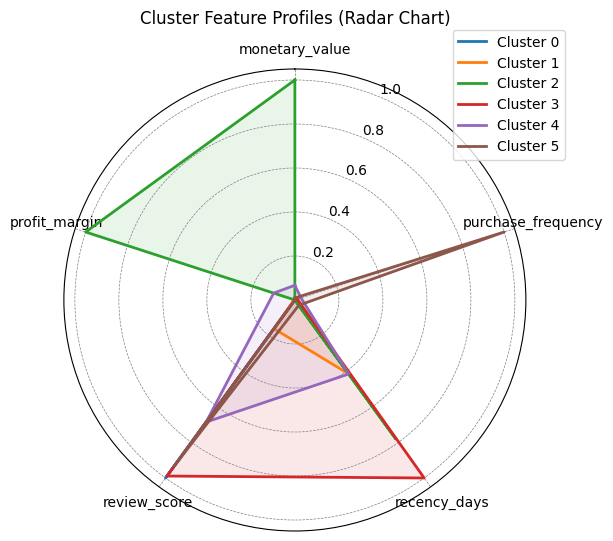

In [92]:
# Prepare cluster profile data
cluster_profile = df_cluster.groupby('cluster')[['monetary_value', 'purchase_frequency', 'recency_days', 'review_score', 'profit_margin']].mean()

# Normalize the values for better comparison
cluster_normalized = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

# Radar chart settings
features = cluster_normalized.columns
N = len(features)
angles =  np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Create radar chart figure
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Set the start angle to 90 degrees (top of the plot)
ax.set_theta_offset(np.pi / 2)
# Set the direction to clockwise
ax.set_theta_direction(-1)

# Plot each cluster's radar line
for i, row in cluster_normalized.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=f'Cluster {i}', linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Add feature labels and legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
# Add gridlines for a more pronounced spider web appearance
num_gridlines = 5
grid_values = np.linspace(0, 1, num_gridlines + 1)[1:]
ax.set_yticks(grid_values)
ax.set_yticklabels([f"{v:.1f}" for v in grid_values])
ax.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.xaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

plt.title("Cluster Feature Profiles (Radar Chart)", y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()



---

##### *General Interpretation of Customer Clusters (Radar Chart)*

The radar chart visualizes distinct customer segments based on behavioral patterns across several key dimensions: *monetary value, profit margin, purchase frequency, review score,* and *recency*. Each cluster represents a group of customers with similar characteristics, allowing for targeted business strategies.

---

#####  *Cluster A – High Spending, Low Satisfaction*

*These customers contribute significantly to revenue and profit but report lower satisfaction levels.*
*This may indicate underlying service or product quality issues that need to be addressed.*

---

##### *Cluster B – Frequent and Satisfied Buyers*

*Customers in this group purchase regularly and provide positive reviews.*
*They are likely loyal and engaged, representing a valuable base for brand advocacy and referral campaigns.*

---

##### *Cluster C – Previously Active, Now Inactive*

*This segment shows high recency, meaning these customers haven’t purchased recently.*
*They may have once been active and valuable but now require re-engagement strategies such as win-back offers.*

---

##### *Cluster D – Low Engagement Across All Dimensions*

*These customers show minimal activity and low impact across all metrics.*
*They may not warrant focused investment unless there's potential for growth.*

---

#### *Overall Trend*

*Customer behavior is diverse and segmented—some are highly profitable but dissatisfied, others are loyal and engaged, while some are drifting away or minimally involved. Understanding these patterns supports more effective decision-making around retention, engagement, and resource allocation.*

---


### *NLP:Natural Language Processing*

### *loading the dataset*

In [93]:
# Load all three datasets
df_reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')
df_items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
df_products = pd.read_csv('../data/raw/olist_products_dataset.csv')

# Merge reviews with order items to get product_id for each review
df_reviews_items = pd.merge(df_reviews, df_items[['order_id', 'product_id']], on='order_id', how='left')

# Merge with products to get product_category_name
df_reviews_full = pd.merge(df_reviews_items, df_products[['product_id', 'product_category_name']], on='product_id', how='left')

# Now you have review, order, and product category info in one DataFrame
nlp_df = df_reviews_full[['review_comment_title', 'review_comment_message', 'product_category_name']]
nlp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113131 entries, 0 to 113130
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_comment_title    13523 non-null   object
 1   review_comment_message  48166 non-null   object
 2   product_category_name   110774 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB


In [94]:
nlp_df = df[['review_comment_title', 'review_comment_message', 'product_category_name']]


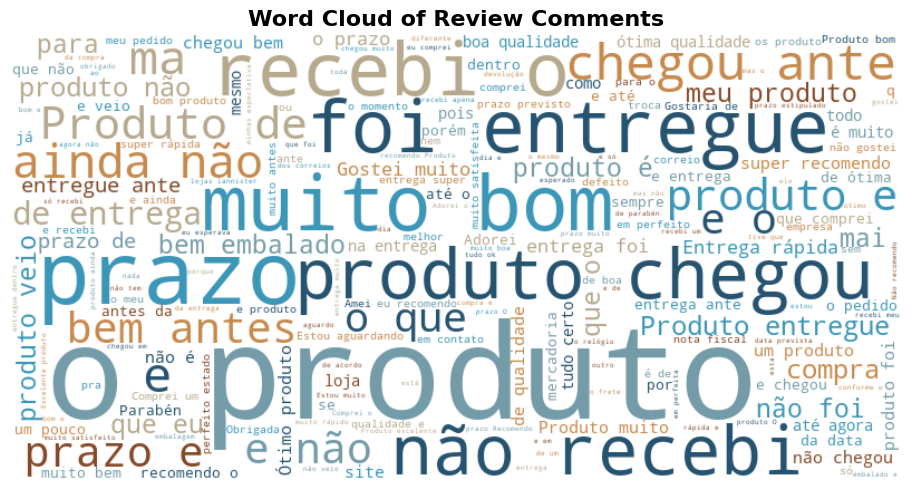

In [95]:
# Define a color function
def color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    return random.choice(colors)

# Example: Word cloud from review comments
plt.figure(figsize=(10, 5))

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(
    ' '.join(df_no_unknown['review_comment_message'].dropna())
)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Review Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

*The word cloud shows that customers focus on product, delivery, and timing in their reviews.*

*Frequent words like “produto:product”, “recebi:received”, and “prazo:deadline” highlight these main topics.*

*Both positive and negative experiences are visible, giving a quick sense of customer priorities.*

### *Natural Language Processing (NLP)*

#### *Data Cleaning*

In [96]:
print("There are {} product categories in the dataset.".format(nlp_df.product_category_name.nunique()))

There are 73 product categories in the dataset.


In [97]:
# Calculating the total number of NaN values in each column of the DataFrame 'nlp_df'
nan_counts = nlp_df.isna().sum()

In [98]:
# Calculating the total number of NaN values in the 'review_comment_message' column of 'nlp_df'
nan_count_review_comment_message = nlp_df['review_comment_message'].isna().sum()
nan_count_review_comment_message

np.int64(31)

### *Removing Duplicates*

In [99]:
def remove_duplicates_nlp_df(nlp_df, column_name='review_comment_message'):
    
    # Remove duplicates based on the specified column, keeping the first occurrence
    nlp_df = nlp_df.drop_duplicates(subset=[column_name], keep='first').reset_index(drop=True)
    
    # Display the total entries after removing duplicates
    print(f"Total entries after removing duplicates in '{column_name}': {nlp_df.shape[0]}")
    
    return nlp_df

# Remove duplicates from 'nlp_df' based on the 'review_comment_message' column
nlp_df = remove_duplicates_nlp_df(nlp_df, 'review_comment_message')

Total entries after removing duplicates in 'review_comment_message': 34526


In [100]:
def clean_reviews(df):
    """
    Cleans the input DataFrame by removing rows with missing values in key columns
    and dropping duplicate review comments.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")
    df = df.drop_duplicates(subset=['review_comment_message'])
    df = df.drop_duplicates(subset=['review_comment_message'])
    return df

df_cleaned = clean_reviews(nlp_df)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34526 entries, 0 to 34525
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_title    34525 non-null  object
 1   review_comment_message  34525 non-null  object
 2   product_category_name   34019 non-null  object
dtypes: object(3)
memory usage: 809.3+ KB


### *Text Preprocessing*

In [101]:
from nltk.corpus import stopwords
import string
# Define Portuguese stopwords
STOP_WORDS = set(stopwords.words('portuguese'))

# Helper function to clean and tokenize text
def clean_and_tokenize(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        return "", []
    
    # Convert to lowercase, remove punctuation, and split into words
    cleaned_text = text.lower().translate(str.maketrans('', '', string.punctuation))
    words = cleaned_text.split()
    
    # Remove stopwords and create tokens
    filtered_words = [word for word in words if word not in STOP_WORDS]
    return " ".join(filtered_words), filtered_words

# Main function to preprocess and clean the dataframe
def preprocess_nlp_df(df):
    # Clean, remove stopwords, and tokenize comments
    df[['review_comment_message_clean', 'review_comment_message_tokens']] = df['review_comment_message'].apply(
        lambda text: pd.Series(clean_and_tokenize(text))
    )
    
    # Remove rows with NaN values in key columns
    df.dropna(subset=['review_comment_title', 'review_comment_message'], inplace=True)
    
    # Drop duplicate rows based on the 'review_comment_message' and 'review_comment_title' columns
    df.drop_duplicates(subset=['review_comment_message', 'review_comment_title'], inplace=True)
    
    return df.reset_index(drop=True)

### *Sentiment Analysis*
*The LeIA library is a Python-based sentiment analysis tool specifically designed for Brazilian Portuguese text. It’s built upon principles similar to the VADER (Valence Aware Dictionary for Sentiment Reasoning) sentiment analysis tool but is adapted for the nuances of the Portuguese language, including common expressions, vocabulary, and grammar structures unique to Brazilian Portuguese.*


*Polarity Scores: SentimentIntensityAnalyzer generates four main scores:*

*Positive (pos): The proportion of positive sentiment in the text.*

*Neutral (neu): The proportion of neutral sentiment.*

*Negative (neg): The proportion of negative sentiment.*

*Compound (compound): An overall sentiment score that combines the positive, neutral, and negative scores into a single value ranging from -1 (very negative) to +1 (very positive).*

In [102]:
# Intaize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(df_cleaned, column_name='review_comment_message_clean'):
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    df_cleaned[f'{column_name}_sentiment'] = df_cleaned[column_name].map(get_sentiment_classification)
    return df_cleaned

df_cleaned = preprocess_nlp_df(df_cleaned)

# Classify sentiment in 'nlp_df' based on the 'review_comment_message_clean' column
nlp_df = classify_sentiment(df_cleaned, 'review_comment_message_clean')

# Display the sentiment results
nlp_df[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(10)

,review_comment_message_clean,review_comment_message_clean_sentiment
0,testei produto ainda veio correto boas condiçõ...,Neutral
1,bom produto,Neutral
2,unknown,Neutral
3,produto exatamente esperava descrito site cheg...,Neutral
4,aguardando retorno loja,Neutral
5,gostei produto,Neutral
6,obrigado atenção lojas lannister perfeito tudo,Neutral
7,correios estäo greve näo recebi nenhum aviso a...,Neutral
8,sempre vou comprar aqui pois melhor parabéns,Neutral
9,demora entregar passou prazo ainda recebi enco...,Neutral


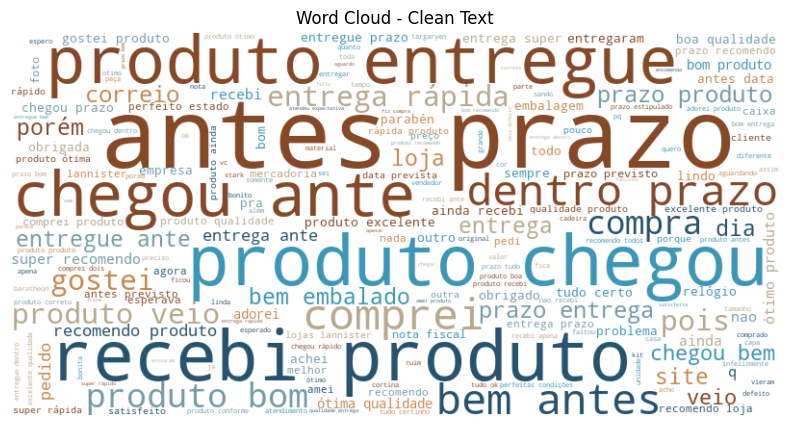

In [103]:
text_combined = " ".join(nlp_df['review_comment_message_clean'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Clean Text")
plt.axis("off")  # Remove the axes
plt.show()

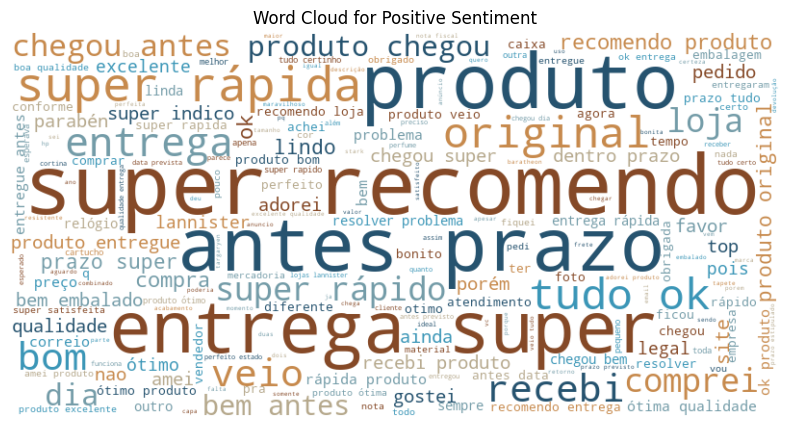

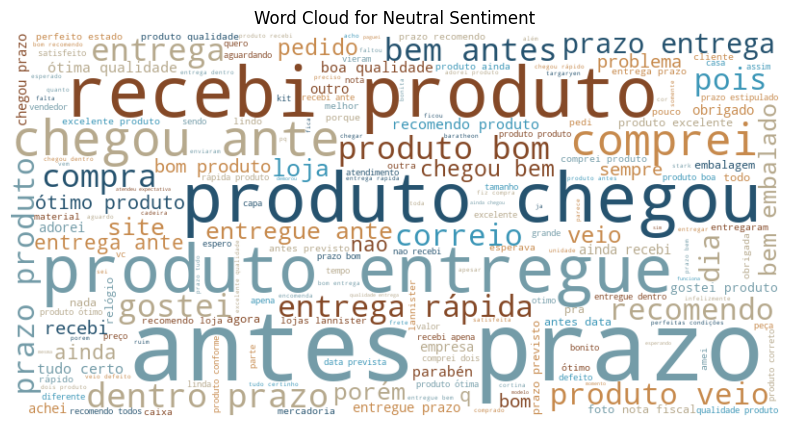

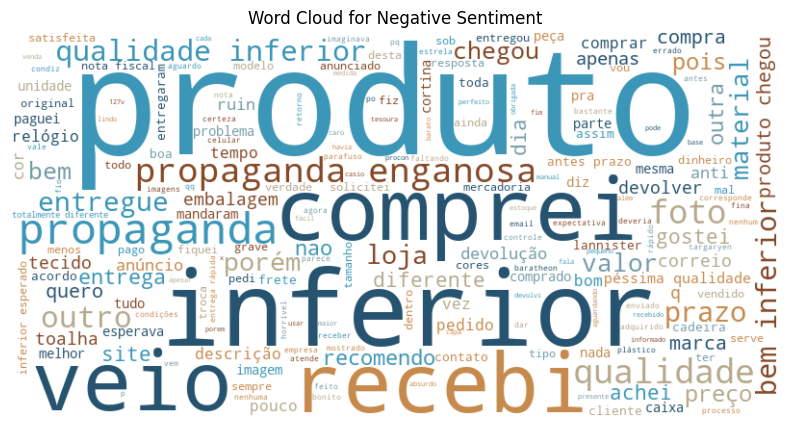

In [104]:
def plot_word_clouds_by_sentiment(df, text_column='review_comment_message_clean', sentiment_column='review_comment_message_clean_sentiment'):
    # Filter text by sentiment
    sentiments = ['Positive', 'Neutral', 'Negative']
    
    for sentiment in sentiments:
        # Filter data by current sentiment
        text_data = " ".join(df[df[sentiment_column] == sentiment][text_column].dropna())
        
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text_data)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment} Sentiment')
        plt.show()
        
# Generate word clouds based on sentiment for the specified columns
plot_word_clouds_by_sentiment(nlp_df, 'review_comment_message_clean', 'review_comment_message_clean_sentiment')

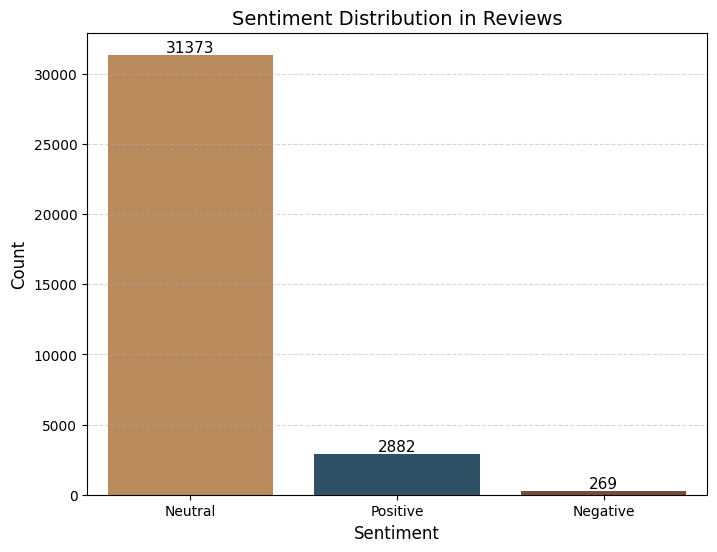

In [105]:
# Plot the sentiment count
custom_palette = {
    "#26536f", "#c78a4d", "#854927"
}

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    x="review_comment_message_clean_sentiment", 
    data=nlp_df, 
    palette=custom_palette
)

# Add labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Distribution in Reviews", fontsize=14)

# Display value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Reduce gridline visibility for a cleaner look
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.5)

plt.show()



*The sentiment distribution plot shows that most review comments are classified as `Neutral`, with far fewer `Positive` and very few `Negative` reviews. This suggests customers are generally neutral in their feedback, with positive experiences being less common and negative ones rare.*